This notebook shows the functions provided by TINC to create parameter spaces and data pools from configuration and output files. There are two methods:

  * Using the output data
  * Using configuration files
  
Using the output can be very convenient as you can create a DataPool automatically to explore the data, but there are cases where you might need to extract the parameter space from configuration files instead, in cases where the parameters are not present in the output data.

In [1]:
%pylab inline
from tinc import *

Populating the interactive namespace from numpy and matplotlib


## tl;dr Create datapools from output

You can create a data pool directly from results using ```create_datapool_from_output()```. This function returns the datapool and parameter space extracted from the data files.

Found more than one potential parameter in files:['Beta', 'T'] 
Using:T 


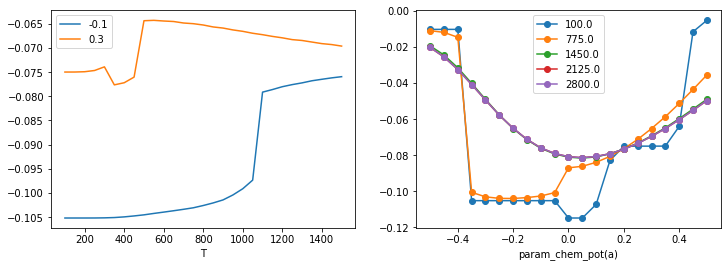

In [4]:
data_dir = r'C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating'
dp,ps  = create_datapool_from_output(data_dir, "results.json", ignore_params=['Beta'], debug = False)

figure(figsize=(12,4))
subplot(1,2, 1)
xlabel("T")
ps.get_dimension("param_chem_pot(a)").value = -0.1
plot(ps.get_parameter("T").values, dp.get_slice("<formation_energy>", "T"))
ps.get_parameter("param_chem_pot(a)").value = 0.3
plot(ps.get_parameter("T").values, dp.get_slice("<formation_energy>", "T"))
legend([-0.1, 0.3])

subplot(1,2, 2)
xlabel("param_chem_pot(a)")
temp_values = linspace(100, 2800, 5)

for temp_val in temp_values:
    ps.get_dimension("T").value = temp_val
    plot(ps.get_parameter("param_chem_pot(a)").get_values(), dp.get_slice("<formation_energy>", "param_chem_pot(a)"), marker='o')
    
legend(temp_values);


# Extracting from configuration files

To extract a parameter space from configuration files, you must provide a data root directory and the name of the configuration file that can be found in subdirectories. This assumes all configuration file names are the same.

You will also need to describe how to extract the information from the configuration files. This is done by specifying the keys where the parameter data is found. For example if the configuration files look like:

```json
{
  "driver" : {
    "mode" : "incremental", 
    "motif" : {
      "configname" : "restricted_auto",
      "_configname" : "SCEL1_1_1_1_0_0_0/0",
      "_configdof" : "$HOME/laptop_share/NbO_rocksalt_gs/mc_runs/fit_13.02/coarse_grid/set2_cooling_grid2/A_3.9B_-19.1/conditions.298/tto/final_state.json"
    },
    "initial_conditions" : {
      "param_chem_pot" : {
        "a" : 3.90,
        "b" : -19.80
      },
      "temperature" : 20.0,
      "tolerance" : 0.001
    },
    "final_conditions" : {
      "param_chem_pot" : {
        "a" : 3.90,
        "b" : -19.80
      },
      "temperature" :2800.0,
      "tolerance" : 0.001
    },
    "incremental_conditions" : {
      "param_chem_pot" : {
        "a" : 0.0,
        "b" : 0.0
      },
      "temperature" : 10.0,
      "tolerance" : 0.001
    }
  }
}

```

You specify the starting value key as: ```driver/initial_conditions/*``` because the starting values are a list within the "driver" and " initial_conditions" keys. A similar string needs to be constructed for end and increment keys.


Current limitations:
  * JSON only
  * space must be described by its boundaries and the incremement
  * Limited format to describe how to extract the information. Currently values must be leaf nodes.

## Extracting parameter space values

The function ```extract_parameter_space_data``` will extract the parameter values as a dictionary. This can be useful as a initial step to ensure values are being extracted correctly.

In [5]:
data_dir = r'C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating'
config_file = 'mc_settings.json'
parameter_start_key = 'driver/initial_conditions/*'
parameter_end_key = 'driver/final_conditions/*'
parameter_increment_key = 'driver/incremental_conditions/*'

extract_parameter_space_data(data_dir, config_file, parameter_start_key, parameter_end_key, parameter_increment_key)

{'param_chem_pot(a)': array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ]),
 'temperature': array([ 100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.,
         550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,  950.,
        1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350., 1400.,
        1450., 1500.])}

## Creating parameter spaces

The ```make_parameter_space``` function returns a fully created parameter space from the configuration files. The only remaining step to perform to make the parameter space usable is to set the path template using ```set_current_path_template```. This template describes how the parameter values map to the filesystem.

In [6]:
data_dir = r'C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating'
config_file = r'mc_settings.json'
parameter_start_key = 'driver/initial_conditions/*'
parameter_end_key = 'driver/final_conditions/*'
parameter_increment_key = 'driver/incremental_conditions/*'

ps = make_parameter_space(data_dir, config_file, parameter_start_key, parameter_end_key, parameter_increment_key, ps_name="casmParams")

ps.print()

 ** ParameterSpace 'casmParams'
   -- Parameter param_chem_pot(a) -0.5 ... 0.5
   -- Parameter temperature 100.0 ... 1500.0




In [7]:
ps.get_dimension("param_chem_pot(a)").value = 0.05
ps.get_dimension("param_chem_pot(a)").value

0.05

In [8]:
ps.get_dimension("param_chem_pot(a)").ids = [f'{v:.4f}' for v in ps.get_dimension("param_chem_pot(a)").values]

ps.set_current_path_template("mu_%%param_chem_pot(a):ID%%_T_100_1500")

In [9]:
# ps.debug = True
ps.get_current_relative_path()
ps.resolve_template("mu_%%param_chem_pot(a):ID%%_T_100_1500")

'mu_0.0500_T_100_1500'

## Data pools for the new parameter space

Once the parameter space has been extracted, a DataPool can be created to access the data across all the directories. After creating the data pool, you need to register the files that contain the data, in this case, the "results.json" file spans the temperature parameter. These data files must be located in the path defined through ```set_current_path_template()``` above.

In [10]:
dp = DataPoolJson("results", ps, "slice_dir")
dp.register_data_file("results.json", "temperature")

In [11]:
dp.get_current_files()

['C:\\Users\\Andres\\source\\repos\\vdv_data\\HfN_FCC_grand_canonical_heating/mu_0.0500_T_100_1500/results.json']

In [12]:
ps.get_current_relative_path()

'mu_0.0500_T_100_1500'

You can query the fields available in the data files:

In [13]:
dp.list_fields()

['<atom_frac(Hf)>',
 '<atom_frac(N)>',
 '<comp(a)>',
 '<comp_n(Hf)>',
 '<comp_n(N)>',
 '<comp_n(Va)>',
 '<formation_energy>',
 '<potential_energy>',
 '<site_frac(Hf)>',
 '<site_frac(N)>',
 '<site_frac(Va)>',
 'Beta',
 'N_avg_samples',
 'N_equil_samples',
 'T',
 'heat_capacity',
 'is_converged',
 'is_equilibrated',
 'param_chem_pot(a)',
 'prec(<atom_frac(Hf)>)',
 'prec(<atom_frac(N)>)',
 'prec(<comp(a)>)',
 'prec(<comp_n(Hf)>)',
 'prec(<comp_n(N)>)',
 'prec(<comp_n(Va)>)',
 'prec(<formation_energy>)',
 'prec(<potential_energy>)',
 'prec(<site_frac(Hf)>)',
 'prec(<site_frac(N)>)',
 'prec(<site_frac(Va)>)',
 'susc_n(Hf,Hf)',
 'susc_n(N,Hf)',
 'susc_n(N,N)',
 'susc_n(N,Va)',
 'susc_n(S,Hf)',
 'susc_n(S,N)',
 'susc_n(S,Va)',
 'susc_n(Va,Hf)',
 'susc_n(Va,Va)',
 'susc_x(S,a)',
 'susc_x(a,a)']

In [14]:
ps.get_dimension("temperature").value = 1500
ps.get_dimension("param_chem_pot(a)").value = -0.1000

You can request slices of data, from a single data file (temperature is the parameter contained in the individual files):

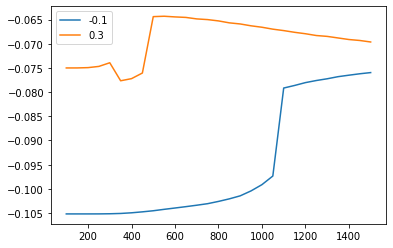

In [15]:
#dp.debug = True
ps.get_dimension("param_chem_pot(a)").value = -0.1
plot(ps.get_parameter("temperature").values, dp.get_slice("<formation_energy>", "temperature"))
ps.get_parameter("param_chem_pot(a)").value = 0.3
plot(ps.get_parameter("temperature").values, dp.get_slice("<formation_energy>", "temperature"))
legend([-0.1, 0.3])

In [16]:
len(dp.get_slice("<formation_energy>", "temperature")), len(ps.get_parameter('temperature').values)

(29, 29)

Or you can request slices that take a single value from a number of results file, when the requested slicing dimension is a dimension that affects the current path:

In [17]:
ps.get_parameter("param_chem_pot(a)").values

array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ])

In [18]:
ps.get_parameter("param_chem_pot(a)").value

0.3

In [21]:
dp.get_slice("<formation_energy>", "param_chem_pot(a)")

File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json


masked_array(data=[-0.02038522, -0.02565508, -0.03260944, -0.04088717,
                   -0.04948895, -0.05787197, -0.06509675, -0.07125869,
                   -0.07595791, -0.07905044, -0.08137295,         nan,
                   -0.07917192, -0.07670514, -0.07349139, -0.06962977,
                   -0.06524893, -0.06035144, -0.05520891, -0.04976849],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [22]:
ps._path_template

'mu_%%param_chem_pot(a):ID%%_T_100_1500'

File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json
File not found: C:\Users\Andres\source\r

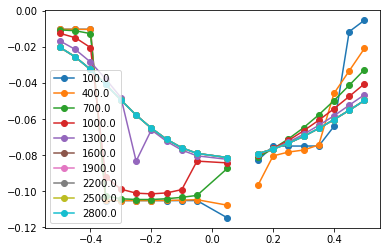

In [23]:
temp_values = linspace(100, 2800, 10)

for temp_val in temp_values:
    ps.get_dimension("temperature").value = temp_val
    plot(ps.get_parameter("param_chem_pot(a)").values, dp.get_slice("<formation_energy>", "param_chem_pot(a)"), marker='o')
    
legend(temp_values);

In [24]:
len(dp.get_slice("<formation_energy>", "param_chem_pot(a)")), len(ps.get_parameter('param_chem_pot(a)').values)

File not found: C:\Users\Andres\source\repos\vdv_data\HfN_FCC_grand_canonical_heating/mu_0.1000_T_100_1500/results.json


(20, 20)

# Making parameter space from output files

You can also extract parameter spaces from output files, to analyze output data, or when the input parameters are available in output data files.

To do this, you must provide a root path and define a function that reads the a data file and returns a dictionary with the possible values each parameter can take according to the data file. The format should be the same provided by the ```extract_parameter_space_data``` function above.

In [ ]:
def read_func(path):
    with open(path) as f:
        j = json.load(f)
    return j

data_dir = r'C:\Users\Andres\source\repos\vdv_data\nbO_2chempot'
ps = extract_parameter_space_from_output(data_dir, "results.json", read_func)
ps.print()

If there are two potential parameters inside the result files, the first one found will be used. You can instruct which ones to ignore using the ```ignore_params=``` argument:

In [ ]:
ps = extract_parameter_space_from_output(data_dir, "results.json", read_func, ignore_params=['Beta'])
ps.print()

## Creating Datapools from output 

You can create a data pool directly from results using ```create_datapool_from_output()```. This function outputs the datapool and parameter space extracted from the data files.

In [ ]:
dp,ps = create_datapool_from_output(data_dir, "results.json", read_func, ignore_params=['Beta'])

In [ ]:
ps.get_parameter("param_chem_pot(b)").value, ps.get_parameter("param_chem_pot(b)").values, ps.get_parameter("param_chem_pot(b)").ids, ps.get_parameter("param_chem_pot(b)").get_space_stride()

In [ ]:
dp.list_fields()

In [ ]:
ps = dp.get_parameter_space()

In [ ]:
ps.get_current_relative_path()

In [ ]:
ps.get_root_path()

In [ ]:
#dp.debug = True
plot(ps.get_parameter("T").get_values(), dp.get_slice("<formation_energy>", "T"));

In [ ]:
ps.get_parameter("param_chem_pot(a)").ids
ps.get_current_relative_path()
ps.is_filesystem_dimension("param_chem_pot(a)")
ps.get_parameter("param_chem_pot(a)").values

In [ ]:
ps.get_common_id([ps.get_parameter("param_chem_pot(a)"),ps.get_parameter("param_chem_pot(b)")], {'T': 0, 'param_chem_pot(a)': 0, 'param_chem_pot(b)': 0})

In [ ]:
ps.is_filesystem_dimension('param_chem_pot(a)')

In [ ]:
ps.resolve_template(ps._path_template, {'T': 0, 'param_chem_pot(a)': 3, 'param_chem_pot(b)': 0})

In [ ]:
dp.get_slice("Beta", "param_chem_pot(a)")

In [ ]:
set(ps.get_parameter("param_chem_pot(a)").values)

In [ ]:
plot(ps.get_parameter("param_chem_pot(a)").get_values(), dp.get_slice("Beta", "param_chem_pot(a)"), marker='o')

TODO... Ignore below...

In [ ]:
import netCDF4

ps_filename = "parameter_space.nc"
sub_dir = sub_dirs[0]
full_path = data_dir + subdir + ps_filename
ps_file = netCDF4.Dataset(full_path, "w", format="NETCDF4")

params = ps_file.createGroup("internal_parameters")
mapped_params = ps_file.createGroup("mapped_parameters")
index_params = ps_file.createGroup("index_parameters")

for param_name, space in param_space.items():
    param_group = rootgrp.createVariable("values","f8",("internal_parameters",))
    mapped_group = rootgrp.createVariable("values","f8",("mapped_parameters",))
    mapped_var_ids = rootgrp.createVariable("ids","s",("mapped_parameters",))
    index_group = rootgrp.createVariable("values","f8",("index_parameters",))


param_var = rootgrp.createVariable("values","f8",("internal_parameters",))
mapped_var = rootgrp.createVariable("values","f8",("mapped_parameters",))
mapped_var_ids = rootgrp.createVariable("ids","s",("mapped_parameters",))
index_params = rootgrp.createVariable("values","f8",("index_parameters",))

ps_file.close()

Testing single filesystem parameter:

In [ ]:
data_dir = r'C:\Users\Andres\source\repos\vdv_data\MonteCarlo_0'
dp,ps = create_datapool_from_output(data_dir, "results.json", ignore_params=["Beta"] )
ps = dp.get_parameter_space()
ps.print()

In [ ]:
ps._path_template

In [ ]:
ps.get_current_relative_path()

In [ ]:
dp.list_fields()

In [ ]:
dp.get_slice("<formation_energy>", "T")

In [ ]:
dp.get_slice("<formation_energy>", "param_chem_pot(a)")

In [ ]:
ps.is_filesystem_dimension("T")